### Scratch book for initial look and working with json files for rock outcrops

Written: 10/03/2023
Last edited: 10/17/ (major edit, transfering most reusable code to outcrop_json_funcs.py)


In [30]:
# run script with package imports and functions so we have access to them while exploring data
%run -i outcrop_json_funcs.py

In [33]:
file_list = get_file_list(os.path.join('.','stewarts_mill_grid_samples/'))
print(file_list)


['./stewarts_mill_grid_samples/smg_18.json', './stewarts_mill_grid_samples/smg_59.json', './stewarts_mill_grid_samples/smg_22.json', './stewarts_mill_grid_samples/smg_157.json', './stewarts_mill_grid_samples/smg_75.json', './stewarts_mill_grid_samples/smg_100.json', './stewarts_mill_grid_samples/smg_63.json', './stewarts_mill_grid_samples/smg_116.json', './stewarts_mill_grid_samples/smg_34.json', './stewarts_mill_grid_samples/smg_141.json', './stewarts_mill_grid_samples/smg_136.json', './stewarts_mill_grid_samples/smg_43.json', './stewarts_mill_grid_samples/smg_161.json', './stewarts_mill_grid_samples/smg_14.json', './stewarts_mill_grid_samples/smg_120.json', './stewarts_mill_grid_samples/smg_55.json', './stewarts_mill_grid_samples/smg_08a.json', './stewarts_mill_grid_samples/smg_2.json', './stewarts_mill_grid_samples/smg_96.json', './stewarts_mill_grid_samples/smg_79.json', './stewarts_mill_grid_samples/smg_80.json', './stewarts_mill_grid_samples/smg_38.json', './stewarts_mill_grid_sa

In [34]:
# example of taking a jmicro vision csv and converting it to a dictionary
coord_path = '/Users/ryan/Dropbox (Princeton)/reef_survey_project/nevada/data_spreadsheets/point_counts/smg_excel_exports/smg_1_Point Counting_random-350_coordinates.csv'
coords_for_dict = jmicro_to_dict(coord_path, 5000, 3800, delimiter=';')
print(coords_for_dict)

[{'class': None, 'x_position': 0.43165888888888887, 'y_position': 0.8492660818713449}, {'class': 'Microb', 'x_position': 0.34205333333333326, 'y_position': 0.3593691520467836}, {'class': None, 'x_position': 0.7298266666666666, 'y_position': 0.7816812865497076}, {'class': None, 'x_position': 0.027234444444444443, 'y_position': 0.03852704678362573}, {'class': 'Microb', 'x_position': 0.25216555555555553, 'y_position': 0.41748464912280703}, {'class': 'Mi', 'x_position': 0.22302611111111115, 'y_position': 0.3250197368421052}, {'class': 'Mi', 'x_position': 0.641491111111111, 'y_position': 0.5265672514619882}, {'class': None, 'x_position': 0.9876366666666665, 'y_position': 0.3319824561403509}, {'class': None, 'x_position': 0.8516055555555555, 'y_position': 0.9054320175438596}, {'class': None, 'x_position': 0.010159999999999999, 'y_position': 0.33857383040935674}, {'class': 'Mi', 'x_position': 0.5426427777777777, 'y_position': 0.7250511695906432}, {'class': None, 'x_position': 0.10731499999999

In [3]:
# start playing with granulometry based upon some matlab code
# just going to work with smg_7 for now
# read in the json
json_folder = os.path.join('.','stewarts_mill_grid_samples/')
f = open(json_folder + 'smg_7.json')
sample_json = json.load(f)

# find the images where the light source is reflectance or fluorescence
reflect_inds = [i for i, d in enumerate(sample_json['images']) if d['light_source'] == 'reflectance']
fluor_inds = [i for i, d in enumerate(sample_json['images']) if d['light_source'] == 'fluorescence']

# read in the first reflectance image
multispec_im = io.imread(sample_json['path_to_ims'] + sample_json['images'][reflect_inds[0]]['file_name']).astype(float)

# read in and append the remaining reflectance images
for ind in reflect_inds[1:]:
    multispec_im = np.dstack((multispec_im,io.imread(sample_json['path_to_ims'] + sample_json['images'][ind]['file_name']).astype(float)))

# read the fluorescence image into the multispec_im
for ind in fluor_inds:
    multispec_im = np.dstack((multispec_im,io.imread(sample_json['path_to_ims'] + sample_json['images'][ind]['file_name']).astype(float)))

# read in the mask and cover up the masked pixels
mask_ind = [i for i, d in enumerate(sample_json['images']) if d['tag'] == 'boundary_mask']
mask_im = io.imread(sample_json['path_to_ims'] + sample_json['images'][mask_ind[0]]['file_name'], plugin='pil')



/Users/ryan/miniconda3/lib/python3.11/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (151301008 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [11]:
# reshape the multispec_im to be a 2d array with the number of bands as the last dimension
column_im = np.reshape(multispec_im, (multispec_im.shape[0]*multispec_im.shape[1], multispec_im.shape[2]))
column_mask = np.reshape(mask_im, (mask_im.shape[0]*mask_im.shape[1], 1))

# prep the column im for pca by removing the masked pixels and normalizing the columns
column_im = column_im[column_mask[:,0] == 255,:]
scaler = StandardScaler()
scaler.fit(column_im)
column_im = scaler.transform(column_im)

# now perform a pca on the column image, masking out the pixels that are masked in the mask image
im_pca = PCA(n_components=column_im.shape[1])
pc_scores = im_pca.fit_transform(column_im)

# put the nans back in the pc scores and shape back into an image
pc_image = np.zeros((column_mask.shape[0], pc_scores.shape[1]))
pc_image[column_mask[:,0] == 255,:] = pc_scores
pc_image = np.reshape(pc_image, (multispec_im.shape[0], multispec_im.shape[1], pc_scores.shape[1]))


In [21]:
# now we can play with granulometry on the first channel of the pc image
# first, we need to rescale the image to be between 0 and 1
grain_im_raw = pc_image[:,:,0]
grain_im_raw = (grain_im_raw - np.min(grain_im_raw))/(np.max(grain_im_raw) - np.min(grain_im_raw))

# do adaptive histogram equalization on the image
grain_im_adapteq = exposure.equalize_adapthist(grain_im_raw, clip_limit=0.03)

In [29]:
# define an arbitrary set of radii to use for the granulometry
radii = np.linspace(10, 1000, 25)

# and we'll actually resize the image in stead of changing the radius of the structuring element
resizes = radii[0]/radii

# because the grains are dark here, we need to invert the image
grain_im_adapteq = 1 - grain_im_adapteq


In [32]:
# now we can loop through the radii and perform the granulometry
# set up an empty volume to hold an opened image for each radius
opened_vols = np.zeros((grain_im_adapteq.shape[0], grain_im_adapteq.shape[1], len(radii)))
for res in resizes:
    # resize the image
    grain_im_resized = rescale(grain_im_adapteq, res)
    # create a disk structuring element with the first, smallest radius
    selem = disk(radii[0])
    # open the image with the structuring element
    opened_im = opening(grain_im_resized, selem)
    # resize the opened image back to the original size
    opened_im = resize(opened_im, grain_im_adapteq.shape, anti_aliasing=True)
    # add the opened image to the opened_vols volume
    opened_vols[:,:,np.where(resizes == res)[0][0]] = opened_im

ValueError: could not broadcast input array from shape (10650,14206) into shape (10652,14204)

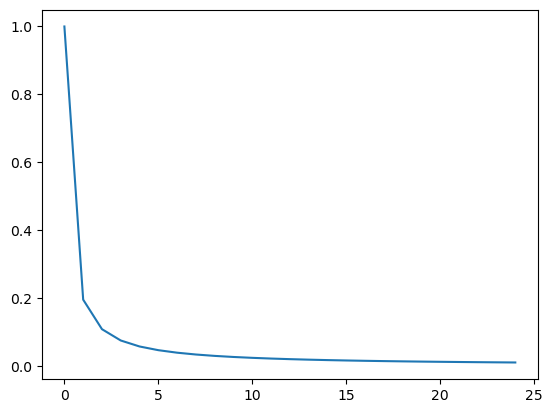